In [123]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.cluster import KMeans

import random

In [124]:
# Return the histogram of an image by applying SIFT + K-means + SPM
# image: the input grayscaled image
# kmeans: python kmeans object used to predict
#             feature type of a new sift descriptor
# M: number of channels (feature typs)
# L: number of SPM levels.
def getHistogram(image, kmeans, M, L):
    x_size = image.shape[0];
    y_size = image.shape[1];
    # Get SIFT key points and descriptor.
    sift = cv2.SIFT();
    key_point, descriptor = sift.detectAndCompute(image, None);
    # Map key points with type.
    cluster_labels = kmeans.predict(descriptor);
    
    # Level 0
    histogram = np.zeros(M);
    weight_0 = 1.0 / (2**L);
    for k in range(0, len(key_point)):
        histogram[cluster_labels[k]] += 1;
    histogram = histogram * weight_0;
    # Other levels
    for l in range(1, L):
        grid_x = 1.0 * x_size / (2**l);
        grid_y = 1.0 * y_size / (2**l);
        weight = 1.0 / (2**(L - l + 1));
        for i in range(0, (2**l)):
            x_min = i * grid_x;
            x_max = x_min + grid_x;
            for j in range(0, (2**l)):
                y_min = j * grid_y;
                y_max = y_min + grid_y;
                histogram_tmp = np.zeros(M);
                # Count and update histogram from this grid.
                for k in range(0, len(key_point)):
                    if (x_min <= key_point[k].pt[0] <= x_max and
                        y_min <= key_point[k].pt[1] <= y_max):
                        histogram_tmp[cluster_labels[k]] += 1;
                histogram_tmp = histogram_tmp * weight;
                histogram = np.hstack((histogram, histogram_tmp));
    return (histogram / np.sum(histogram)); # Normalization

In [125]:
# Return the kmeans object (vocabulary)
# patches: the training gray image set
# M: size of feature types
# sampleNumber: number of small samples from each patch image, default=8
# samplePatchSize: length of the square sample, default 16
def getVocabulary(imageSet, M, sampleNumber=8, samplePatchSize=16):
    descriptor_bank = None;
    for img in imageSet:
        # Choose 8 random 16*16 patches from img
        for i in range(0, sampleNumber):
            x = random.randint(0, img.shape[0] - samplePatchSize);
            y = random.randint(0, img.shape[1] - samplePatchSize);
            currentImg = img[x:x+samplePatchSize, y:y+samplePatchSize];
            # Get sift descriptor
            sift = cv2.SIFT();
            key_point, descriptor = sift.detectAndCompute(currentImg, None);
            if descriptor is None:
                continue;
            # Add descriptor to descriptor_bank
            if descriptor_bank is None:
                descriptor_bank = descriptor;
            else:
                descriptor_bank = np.vstack((descriptor_bank, descriptor));
    print "Total number of descriptors: {}".format(descriptor_bank.shape[0]);
    # Doing K-means to build vocabulary
    vocabulary = KMeans(init='random', n_clusters=M, n_init=10);
    vocabulary.fit(descriptor_bank);
    return vocabulary;

In [126]:
trainingDir = '/oasis/projects/nsf/csd395/yuncong/CSHL_data_patches/patches/';
savingFileName = '/oasis/projects/nsf/csd395/ruogu/vocabulary/vocabulary.npy';

In [127]:
# Load data and convert to grayscale
trainingImages = [];
fileNames = os.listdir(trainingDir);
for fileName in fileNames:
    # print fileName;
    images = np.load(trainingDir + fileName);
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY);
        trainingImages.append(img);
print "Number of image patches in training set: {}".format(len(trainingImages));

Number of image patches in training set: 193797


In [128]:
trainingSamples = random.sample(trainingImages, 10000);

In [130]:
M = 200; # vocabulary size
vocabulary = getVocabulary(trainingSamples, M);

Total number of descriptors: 29321


In [132]:
# Save vocabulary
np.save(savingFileName, vocabulary.cluster_centers_);

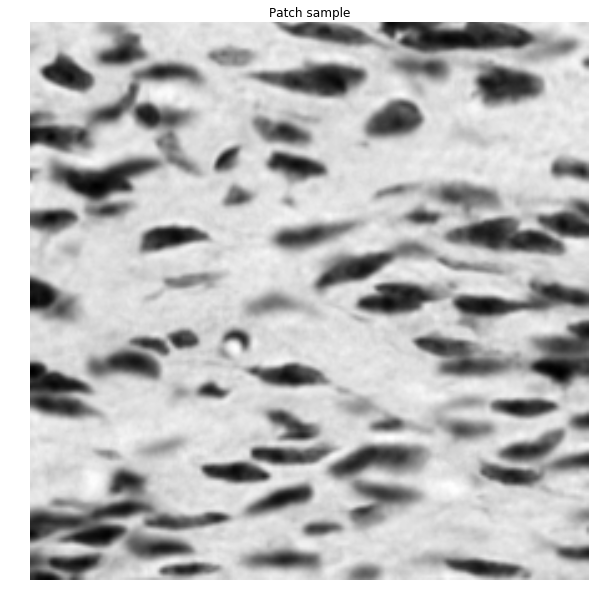

In [136]:
plt.figure(figsize=(10, 10));
plt.imshow(trainingImages[0], cmap=plt.cm.gray);
plt.axis('off');
plt.title('Patch sample');